# Linear Regression from Strategic Data Sources: Counter-examples

This notebook contains the necessary information to replicate the counter-examples from https://arxiv.org/abs/1309.7824 that shows that GLS is not optimal. 



## 1D model (examples 1 and 2)

We first define the functions that we use to compute the Nash equilibrium of the game.

In [1]:
import scipy.optimize as opt
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.formatter.offset_threshold'] = 10

def privacy_cost(l, exponent, scaling_factor=1):
    """ Returns the cost a agent endures for producing data with precision l
        in case of monomial cost function"""
    return (l/scaling_factor)**exponent

def estimation_cost(L, X, D):
    """Returns the estimation cost of the game given:
        - The vector of precision given by agents L
        - The data points X
        - The characterization of the estimator as GLS plus a perturbation matrix D
        - The number of agents nF
        We only consider a one dimensional setting with the scalarizatin being the identity function"""
    d=len(X[0]) # dimension
    n=len(L) # number of agents
    var = np.zeros((d,d))
    for i in range(n):
        var += L[i]*np.tensordot(X[i],X[i],axes=0)
    GLS_cost = np.trace(np.matrix(var)**(-1))
    D_cost = sum([D[i]**2/L[i] for i in range(n)])
    return GLS_cost + D_cost

def potential(L, X, D,exponents):
    """The value of the potential function given
        - The vector of precision given by agents L
        - The data points X
        - The characterization of the estimator as GLS plus a perturbation matrix D
        """
    estim_cost = estimation_cost(L, X, D)
    indiv_cost = np.sum([privacy_cost(L[i], exponents[i]) for i in range(len(L))])
    return indiv_cost + estim_cost

def covarianceEquilibrium(X, D, exponents):
    """
    Returns the estimation cost that corresponds to the matrix D
    """
    n = len(X)
    bnds = [[1e-10, 1] for i in range(n)]
    L0 = np.ones(n)
    tol = 1e-20
    # Computes the equilibrium of the game by minimizing the potential function
    sol = opt.minimize(potential, L0, args=(X, D, exponents), bounds=bnds, tol=tol)
    # Computes the estimation cost achieved at the equilibrium
    return estimation_cost(sol.x, X, D), sol.x

### Types of "$D$"-matrix considered

We considered two types of perturbed estimators $D$:
- "onlyWorst=True" corresponds to the first example of the paper (we only perturbed the "bad" agents)
$$D=[value\dots value, -value\dots -value, 0\dots 0]$$
- "onlyWorst=False" corresponds to the second example of the paper
$$D=[value\dots value, -value\dots -value]$$



In [2]:
def perturbation_matrix_1Dexamples(example_number):
    """Creates a perturbation matrix with a given value which affects
    either all agents or only the worst agent. The matrix is created
    in such a way that the resulting estimator is unbiaised
    """
    if example_number==1:
        return np.array([[1],[-1]])
    else:
        return np.array([[1],[-1],[0],[0]])
    
def exponents_1D_examples(example_number):
    if example_number==1:
        return np.array([1.01,20])
    else:
        return np.array([1.01,1.01,1.1,1.1])
    
def X_1D_examples(example_number):
    if example_number==1:
        return np.array([[1],[1]])
    else:
        return np.array([[1],[1],[1],[1]])

In [3]:
def compute_for_example(deltaMax, example_number):
    X = X_1D_examples(example_number)
    E = exponents_1D_examples(example_number)
    D = perturbation_matrix_1Dexamples(example_number)
    deltas = np.linspace(0,deltaMax,100)
    costs_precs = [covarianceEquilibrium(X,np.sqrt(delta)*D,E) for delta in deltas]
    costs = np.array([cp[0] for cp in costs_precs])
    precisions = np.array([cp[1] for cp in costs_precs])
    return deltas,costs,precisions

## Example 1: two agents
everyone receives a perturbation of the same intensity

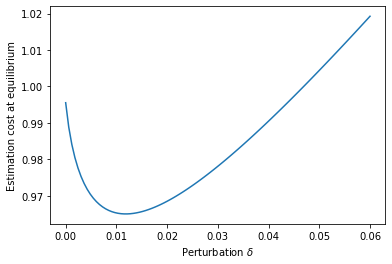

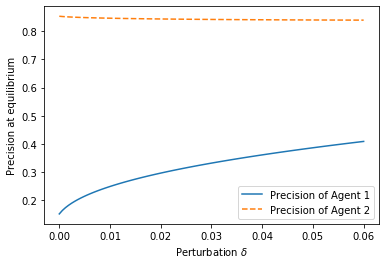

In [4]:
plt.figure()
deltas, costs, lambdas = compute_for_example(0.06,1)
plt.plot(deltas,costs)
plt.ylabel('Estimation cost at equilibrium')
plt.xlabel('Perturbation $\delta$')
plt.savefig('example1.pdf',bbox_inches='tight')

plt.figure()
plt.plot(deltas,lambdas[:,0])
plt.plot(deltas,lambdas[:,1],'--')
plt.ylabel('Precision at equilibrium')
plt.xlabel('Perturbation $\delta$')
plt.legend(['Precision of Agent 1','Precision of Agent 2'])
plt.savefig('example1_precision.pdf',bbox_inches='tight')


## Example 2

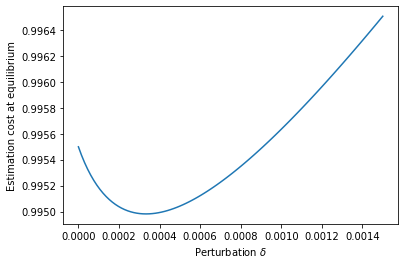

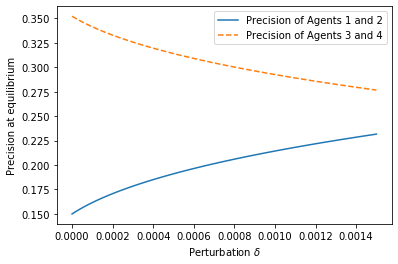

In [5]:
plt.figure()
deltas, costs, lambdas = compute_for_example(0.0015,2)
plt.plot(deltas,costs)
plt.ylabel('Estimation cost at equilibrium')
plt.xlabel('Perturbation $\delta$')
plt.savefig('example2.pdf',bbox_inches='tight')

plt.figure()
plt.plot(deltas,lambdas[:,0])
plt.plot(deltas,lambdas[:,2],'--')
plt.ylabel('Precision at equilibrium')
plt.xlabel('Perturbation $\delta$')
plt.legend(['Precision of Agents 1 and 2','Precision of Agents 3 and 4'])
plt.savefig('example2_precision.pdf',bbox_inches='tight')


## Example 3: $d$-dimensional model with $d+1$ agents

We first redefine a function for the example 3

In [6]:
def compute_costs_and_precisions_d_plus_1(d, delta, exps):
    def e(i):
        res = np.zeros(d)
        res[i] = 1
        return res
    X = [e(i) for i in range(d)]
    X.append(np.ones(d)/d) 
    exponents = np.ones(d+1)*exps[0]
    exponents[d] = exps[1]
    D = np.ones(d+1)*np.sqrt(delta)
    D[d] = -d*np.sqrt(delta)
    return covarianceEquilibrium(X,D,exponents)

import pickle
try: 
    with open('data.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        datas = pickle.load(f)
    print('data successfully loaded')
except:
    datas = dict([])

data successfully loaded


In [7]:
#datas = dict([]) # uncomment this line to recompute simulations for the D-dimensional model 
deltas_max = [1.5e-3,2.5e-5,2.5e-7,2e-8]
for i,dim in enumerate([2,5,10,15]):
    print('computing dim =',dim,end='...')
    if (dim,'d+1 example') in datas: 
        print('done')
        continue
    deltas = np.linspace(0,deltas_max[i],100)
    costs_precs = [compute_costs_and_precisions_d_plus_1(dim,delta,[20,1.5]) for delta in deltas]
    costs = np.array([cp[0] for cp in costs_precs])
    precisions = np.array([cp[1] for cp in costs_precs])
    datas[(dim,'d+1 example')] = (deltas,costs,precisions)
    print('done')

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(datas, f, pickle.HIGHEST_PROTOCOL)

computing dim = 2...done
computing dim = 5...done
computing dim = 10...done
computing dim = 15...done


dim= 2
dim= 5
dim= 10
dim= 15


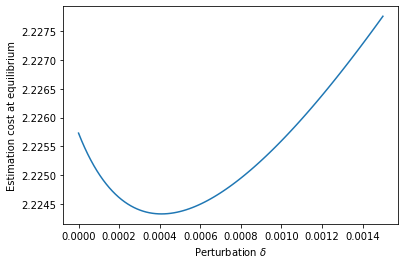

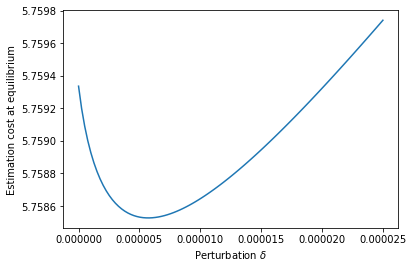

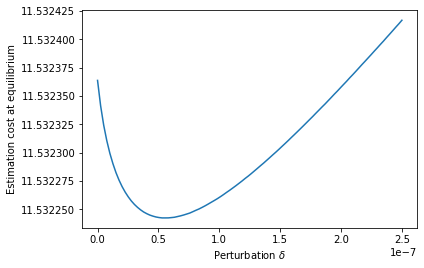

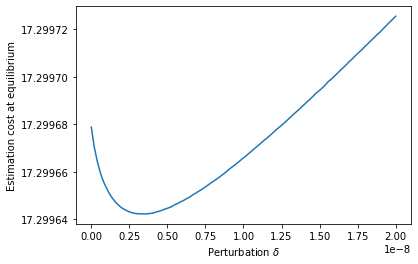

In [8]:
for dim in [2,5,10,15]:
    print('dim=',dim)
    deltas,costs,precisions = datas[(dim,'d+1 example')]
    fig=plt.figure()
    plt.plot(deltas,costs)
    plt.ylabel('Estimation cost at equilibrium')
    plt.xlabel(r'Perturbation $\delta$')
    fig.savefig('perturbation_dim{}.pdf'.format(dim), bbox_inches='tight')

# Other example (not in the paper): $d$-dimensional examples (with $d+2$ agents)

In [9]:
def compute_costs_and_precisions(d, delta, exps):
    def e(i):
        res = np.zeros(d)
        res[i] = 1
        return res
    X = [e(i) for i in range(d)]
    X.append(np.ones(d)) 
    X.append(np.ones(d))
    exponents = np.ones(d+2)*exps[0]
    exponents[d+1] = exps[1]
    D = np.zeros(d+2)
    D[d] = delta
    D[d+1] = -delta
    return covarianceEquilibrium(X,D,exponents)

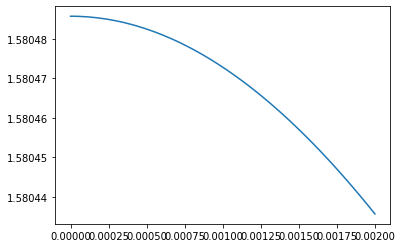

In [10]:
# dim=2
dim=2
deltas = np.linspace(0,.002,100)
costs = [compute_costs_and_precisions(dim,delta, [20,1.5])[0] for delta in deltas]
plt.plot(deltas,costs)

In [11]:
#datas = dict([])
for dim,ylim in [(2,0.025**2),(5,0.0001),(10,0.005**2),(15,0.003**2)]: #range(1,16):
    print('computing dim =',dim,end='...')
    if dim in datas: 
        print('done')
        continue
    deltas = np.linspace(0,ylim,100)
    costs_precs = [compute_costs_and_precisions(dim,delta,[20,1.5]) for delta in deltas]
    costs = np.array([cp[0] for cp in costs_precs])
    precisions = np.array([cp[1] for cp in costs_precs])
    datas[dim] = (deltas,costs,precisions)
    print('done')

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(datas, f, pickle.HIGHEST_PROTOCOL)

computing dim = 2...done
computing dim = 5...done
computing dim = 10...done
computing dim = 15...done


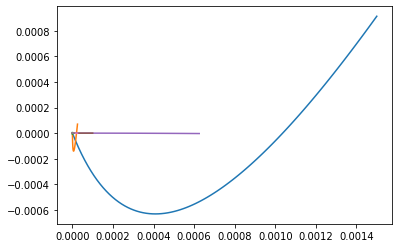

In [12]:
for dim in datas:
    deltas,costs,precisions = datas[dim]
    plt.plot(deltas,costs/costs[0]-1)
